In [3]:
import numpy
import pandas

from matplotlib import pyplot as plt
#%matplotlib inline  

import simProjectAnalysis as spa



# Loading data and getting an overview

We start by loading the spiking data of a set of hippocampus simulations.
We have already extracted the spikes and exported them into an hdf5 file. Here, we load the spikes from that file.

In [4]:
spikes = spa.collection_from_h5("hippocampus_spikes_for_mooc.h5", 1)

The data structure we get splits the spikes into arrays and assigns to each of them a combination of labels that are associated with simulation or analysis conditions. Let's list those conditions and the labels associated with them.

In [5]:
for cond in spikes.conditions():
    print("{cond}:".format(cond=cond))
    for lbl in spikes.labels_of(cond):
        print("\t-{lbl}".format(lbl=lbl))

ana_mtype:
	-SLM_PPA
	-SO_BP
	-SO_BS
	-SO_OLM
	-SO_Tri
	-SP_AA
	-SP_BS
	-SP_CCKBC
	-SP_Ivy
	-SP_PC
	-SP_PVBC
	-SR_SCA
type:
	-block_interneurons
	-increase_minis
	-reference


In this small example we have two conditions: "ana_mtype", referring to the morphological class that is being analyzed and "type", referring to the simulation conditions. We have three such conditions, "reference", one with increased miniature psp frequencies and one where synaptic transmission from interneurons is blocked.

We can use the "spikes.get" functionality to specify and access a specific combination of conditions.

In [6]:
print(spikes.get2(type="reference", ana_mtype="SP_Ivy")[:10])

[[9.3000e+00 1.7900e+04]
 [9.5250e+00 1.7998e+04]
 [9.7000e+00 1.7952e+04]
 [1.2625e+01 1.7581e+04]
 [1.3250e+01 1.7686e+04]
 [1.3925e+01 1.7685e+04]
 [1.4775e+01 1.8024e+04]
 [2.2900e+01 1.7732e+04]
 [3.5900e+01 1.7894e+04]
 [3.9425e+01 1.7918e+04]]


We see the result is a numpy array with two columns: The first specifies the time of a spike event and the second one a unique identifier of the neuron that is spiking. With that, we can start looking at and comparing simulations.

# Plotting the data

To begin with, we write a utility function that creates one subplot for each label of some condition ("cond"), then plots the results associated with that label with a specified "plot_function". Further condition / label combinations can be given as keyword-arguments. Here, we plot a raster plot of spikes of SP_PC neurons.

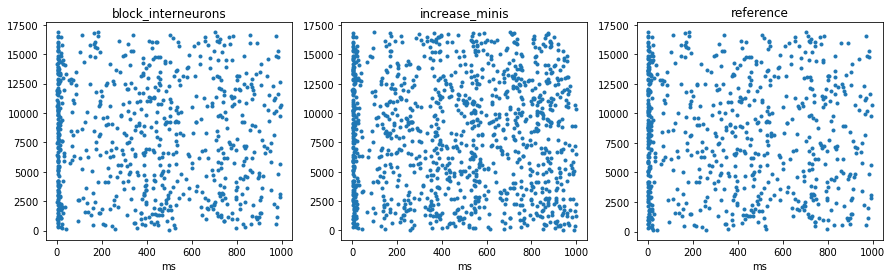

In [7]:
def plot_in_subplots(data, cond, plot_function, xlabel="", ylabel="", plot_kwargs={}, **kwargs):
    lbls = data.labels_of(cond)
    plt.figure(figsize=(5 * len(lbls), 4))
    for i, tp in enumerate(lbls):
        ax = plt.subplot(1, len(lbls), i + 1)
        kwargs[cond] = tp
        datum = data.get2(**kwargs)
        plot_function(ax, datum, **plot_kwargs)
        ax.set_title(tp); ax.set_xlabel(xlabel); ax.set_ylabel(ylabel)

plot_spikes = lambda ax, x: ax.plot(x[:, 0], x[:, 1], '.')
plot_in_subplots(spikes, "type", plot_spikes, xlabel="ms", ana_mtype="SP_PC")

We see that increasing spontaneous release ("increase_minis") seems to substantially increase the amount of firing. Surprisingly, blocking the interneurons appears to have little effect. Does it really not increase firing to remove inhibition? Let's find out by calculating and plotting the average firing rates of all neuron morphological classes.

To that end, we need to know how many neurons of each morphological class the simulation contains. We load the required data using pandas and continue to count the numbers of neurons.


In [8]:
fn_mtypes = "hippocampus_mtypes_for_mooc.h5"
mtypes = pandas.read_hdf(fn_mtypes, "mtypes")

n_per_mtype = mtypes.value_counts()

Now we can calculate average firing rates. We first write a function that in a list of labels of morphological classes and a second list of the numpy arrays containing the spikes for those classes. We use the function by "pool"ing the spikes along the "ana_mtype" condition that specifies the morphological class.

Then, we write a function to plot the resulting firing rates as horizontal bars and use our old helper function to plot all three simulation conditions.

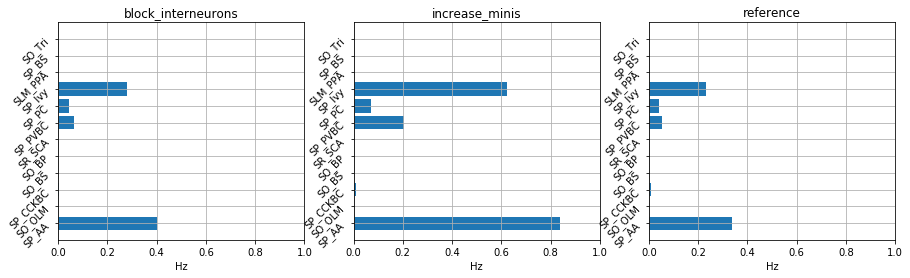

In [9]:
sim_duration_seconds = 1.

def firing_rates(lst_of_mtypes, lst_of_spikes):
    return dict([(m, s.shape[0] / (n_per_mtype[m] * sim_duration_seconds))
                for m, s in zip(lst_of_mtypes, lst_of_spikes)])

def plot_firing_rates(ax, fr, xlim=[0, 1.]):
    mtype_labels = fr.keys()
    ax.barh(range(len(mtype_labels)), [fr[m] for m in mtype_labels])
    ax.set_yticks(range(len(mtype_labels)))
    ax.set_yticklabels(mtype_labels, rotation=45.)
    ax.set_xlim(xlim)
    ax.grid(True)

rates = spikes.pool(["ana_mtype"], func=firing_rates, xy=True)
plot_in_subplots(rates, "type", plot_firing_rates, xlabel="Hz")

We see that the interneuron block did slightly increase firing rates of SP_AA, SP_Ivy, SP_PC and SP_PVBC neurons, but not as much as the increased spontaneous release. We also see that only those four morphological types fire at a substantial rate at all.

Let's actually calculate the relative increase in average firing rate. To this end, we first write a simple function that takes two results in the form of a morphological class -> firing rate dictionary and returns the relative increase in the same form.
We then use the "extended_map" function to apply this comparison. Giving "rates" also as the second argument means we are comparing the firing rates to themselves, but specifying "ignore_conds=["type"]" means we compare all combinations of pairs of simulation conditions. 

We then use our plot function from before to plot results where the first item of that pair was a reference simulation ("arg0_type="reference"") for different values of the second item ("arg1_type"), i.e. firing rates for all simulation conditions, relative to the reference. We can equally use "arg0_type="increase_minis"" to plot results relative to that condition.

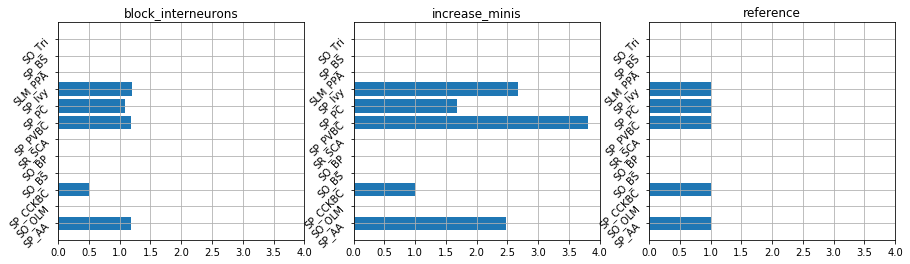

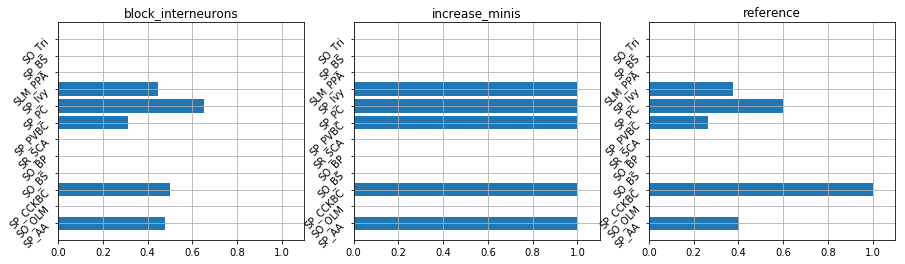

In [10]:
def fr_increase(relative_to, value):
    epsilon = 1E-6
    return dict([(k, value.get(k, numpy.NaN) / (relative_to.get(k, numpy.NaN) + epsilon))
                for k in value.keys()])

rel_increase = rates.extended_map(fr_increase, [rates], ignore_conds=["type"], iterate_inner=True)

plot_in_subplots(rel_increase, "arg1_type",
                 plot_firing_rates,
                 plot_kwargs={"xlim": [0, 4]}, arg0_type="reference")

plot_in_subplots(rel_increase, "arg1_type",
                 plot_firing_rates,
                 plot_kwargs={"xlim": [0, 1.1]}, arg0_type="increase_minis")

# Spiking correlation

Next, we look at the correlation of spiking activity of the various morphological classes.

For the purpose of this exercise, we simply calculate the normalize correlation of the time series of average firing rates, i.e. of the PSTHs for the various morphological classes.

We start by calculating the PSTHs as usual: By defining the function that makes a single psth, then using it in a "map" operation on the spiking results.

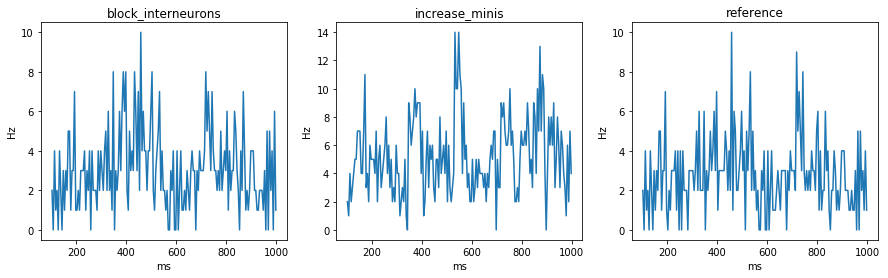

In [11]:
time_bin_sz = 5.

def make_psth(s, skip=100):
    bins = numpy.arange(skip, 1000 + time_bin_sz, time_bin_sz)
    t = 0.5 * (bins[:-1] + bins[1:])
    return t, numpy.histogram(s[:, 0], bins=bins)[0]

psths = spikes.map(make_psth)
plot_in_subplots(psths, "type", lambda ax, x: ax.plot(*x),
                 xlabel='ms', ylabel='Hz', ana_mtype="SP_PC")



And now we calculate the correlations between morphological classes as usual: By first defining a simple function, then applying it to the data structure. Here, we apply it to the psths using the "transform" function, because the correlation function introduces a new condition: "pair", specifying the pair of morphological classes for a given correlation profile.

Once again, we then define a plot function and use it in our helper function.

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in divide
  after removing the cwd from sys.path.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in divide
  This is separate from the ipykernel package so we can avoid doing imports until


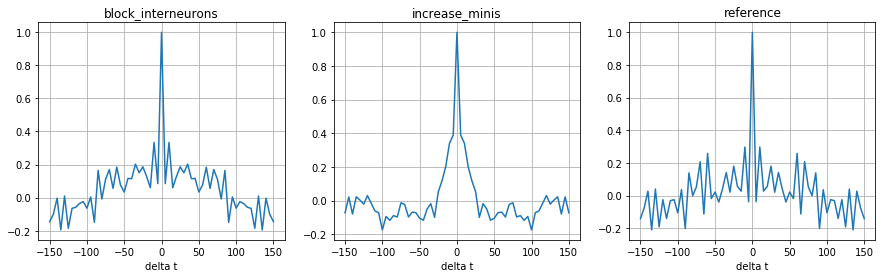

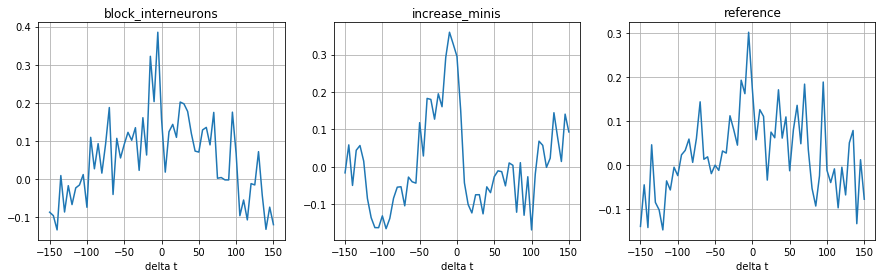

In [13]:
def correlation_analysis(lst_of_mtypes, lst_of_psths, width=150.0):
    def correlation_profile(a, b):
        a = (a - numpy.mean(a)) / numpy.std(a)
        b = (b - numpy.mean(b)) / numpy.std(b)
        return numpy.convolve(a, b[-1::-1], 'same') / numpy.convolve(numpy.ones_like(a), numpy.ones_like(b), 'same')
    
    for i, a in enumerate(lst_of_psths):
        _, a = a
        for j, b in enumerate(lst_of_psths):
            t, b = b
            t = t - t[len(t) / 2]
            v = correlation_profile(a, b)
            v = v[numpy.abs(t) <= width]; t = t[numpy.abs(t) <= width]
            yield (t, v), dict([("pair", (lst_of_mtypes[i], lst_of_mtypes[j]))])

correlations = psths.transform(["ana_mtype"], func=correlation_analysis, xy=True)

def correlation_plot(ax, v):
    t, c = v
    ax.plot(t, c)
    ax.grid(True)
plot_in_subplots(correlations, "type", correlation_plot, xlabel="delta t", pair=("SP_PC", "SP_PC"))
plot_in_subplots(correlations, "type", correlation_plot, xlabel="delta t", pair=("SP_PC", "SP_Ivy"))